In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nycu-dilab-2023-onboard/data_train.csv
/kaggle/input/nycu-dilab-2023-onboard/data_test.csv
/kaggle/input/nycu-dilab-2023-onboard/answer_train.csv
/kaggle/input/nycu-dilab-2023-onboard/answer_sample.csv


# Requirement
 ## 1. Load Data
 
 ## 2. Data Preprocessing
   -  Feature Engineering
     - EDA
     - Data Cleaning
     - Feature Creation and Integration
     - Feature Transformation
     - Feature Extraction
   - Imbalanced Data
     - The Nature of Imbalance Learning Problem
     - The Solutions of Imbalance Learning
     - The Tool of Imbalance Learning
   - Machine Learning Workflow
     - Split Data
 
## 3. Training & Testing
   
   - Machine Learning Workflow
     - Cross Validation
     - Model Training
     - Hyper-Parameter Tuning

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling
#from pandas_profiling import ProfileReport

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import KFold

import csv
import time

def generate_csv(ypredict, filename = 'result.csv'):
    with open(filename,'w',newline = '') as fd:
        writer = csv.writer(fd)
        writer.writerow(['index','default.payment.next.month'])

    for index,pred in enumerate(ypredict):
        with open(filename,'a',newline = '') as fd:
            writer = csv.writer(fd)
            writer.writerow([index,pred])
            
def show_result(ground_truth, prediction):
    print("Accuracy: ", accuracy_score(ground_truth, prediction))
    print("Precision: ",precision_score(ground_truth, prediction))
    print("Recall: ",recall_score(ground_truth, prediction))
    
    plt.figure(figsize=(4,3))
    cm = confusion_matrix(ground_truth, prediction)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    return accuracy_score(ground_truth, prediction)

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


# Load Data

In [3]:
train_x = pd.read_csv('/kaggle/input/nycu-dilab-2023-onboard/data_train.csv')
train_x = train_x.iloc[:,1:-1]
train_y = pd.read_csv('/kaggle/input/nycu-dilab-2023-onboard/answer_train.csv')
train_y = train_y.iloc[:,-1]
test_x = pd.read_csv('/kaggle/input/nycu-dilab-2023-onboard/data_test.csv')
test_x = test_x.iloc[:,1:-1]
rawdata = pd.concat([train_x, train_y], axis=1, join='inner')

# Data Preprocessing
**This part is the most important in this week.**

You should write down as Markdown type below the code:
1. Why you use this EDA?
2. What information you get from this EDA?
3. According to the result of EDA, what is your next step?


## EDA

In [4]:
# Transform Categorical Data
data = rawdata.copy()
for column in data.columns:
    if data[column].dtype == 'int64':  # Check if the column data type is integer (int64)
        data[column] = data[column].astype('category')
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,default.payment.next.month
0,100000.0,2,1,2,38,2,2,2,2,2,...,39750.0,40298.0,40835.0,41529.0,500.0,3500.0,1500.0,1500.0,1500.0,1
1,130000.0,2,2,2,25,0,0,0,0,0,...,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,0
2,130000.0,2,3,2,36,0,0,0,0,0,...,124824.0,123174.0,100585.0,97687.0,5963.0,6316.0,4845.0,3471.0,3673.0,0
3,50000.0,2,2,1,44,0,0,0,0,0,...,7241.0,8249.0,8414.0,8590.0,1109.0,1129.0,1137.0,302.0,312.0,0
4,110000.0,2,3,1,53,0,0,0,0,0,...,108555.0,106692.0,103971.0,104140.0,5400.0,4200.0,5200.0,3800.0,3900.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,90000.0,1,2,1,35,8,7,6,5,4,...,108539.0,106001.0,103816.0,101878.0,0.0,0.0,0.0,0.0,0.0,1
23996,360000.0,2,1,1,34,-2,-2,-2,-2,-2,...,1874.0,6330.0,-200.0,-200.0,15658.0,1874.0,6330.0,0.0,0.0,0
23997,30000.0,2,2,2,21,0,0,0,0,0,...,23485.0,27339.0,25091.0,0.0,2019.0,2511.0,10000.0,502.0,0.0,0
23998,230000.0,2,1,2,34,-1,2,-1,-1,2,...,119.0,699.0,383.0,32774.0,0.0,1000.0,1000.0,0.0,33500.0,1


In [5]:
#numerical statistics
data.describe()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5
count,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000
mean,167673.833333,51311.230333,49220.228167,4.707189e+04,43378.444333,40461.174708,38986.362375,5637.110208,6.000908e+03,5294.564208,4830.345500,4787.776167
std,129986.547905,73651.273193,71074.875580,6.938425e+04,64402.698035,61004.686364,59821.591856,16245.208160,2.326556e+04,18360.029134,15901.815481,15116.982543
min,10000.000000,-165580.000000,-69777.000000,-1.572640e+05,-81334.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,50000.000000,3479.750000,2925.000000,2.649250e+03,2326.750000,1790.000000,1258.500000,1000.000000,8.475000e+02,392.000000,290.000000,248.750000
50%,140000.000000,22352.500000,21150.000000,2.008450e+04,19000.000000,18102.000000,17068.500000,2100.000000,2.010000e+03,1801.000000,1500.000000,1500.000000
75%,240000.000000,67384.000000,64229.500000,6.031150e+04,54599.750000,50468.500000,49132.500000,5012.000000,5.000000e+03,4515.250000,4031.000000,4060.000000
max,1000000.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000


In [6]:
# categorical statistic
categorical = data.select_dtypes(include='category')
categorical.describe()

,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default.payment.next.month
count,24000,24000,24000,24000,24000,24000,24000,24000,24000,24000,24000
unique,2,7,4,55,11,10,11,11,10,10,2
top,2,2,2,29,0,0,0,0,0,0,0
freq,14468,11225,12779,1308,11819,12585,12623,13206,13617,13073,18686


<Axes: >

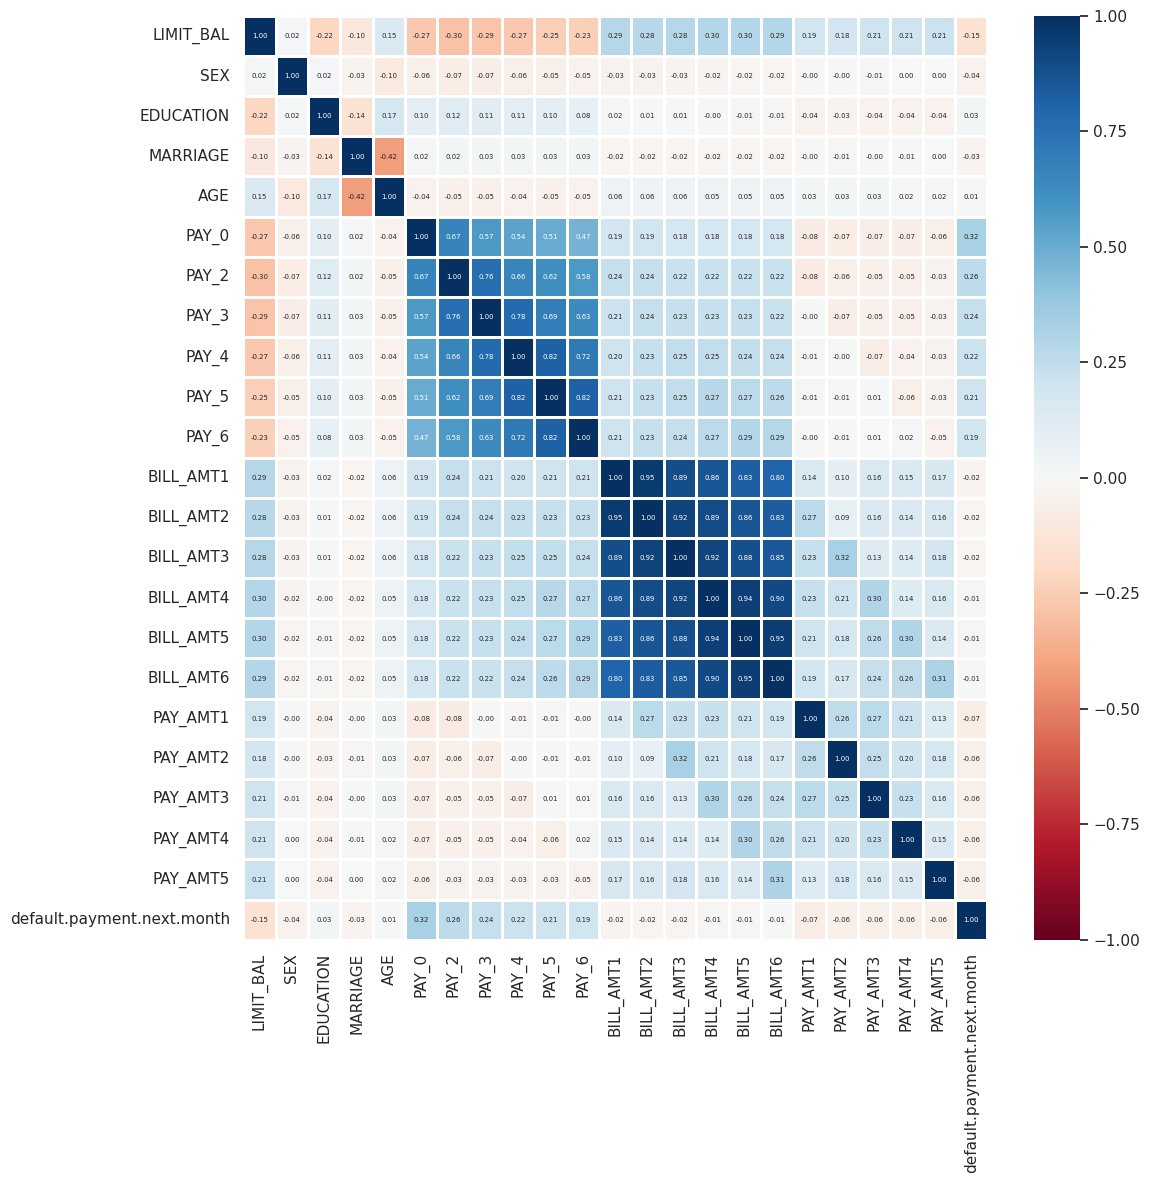

In [7]:
# Correlation
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(rawdata.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 5}, cmap = "RdBu")

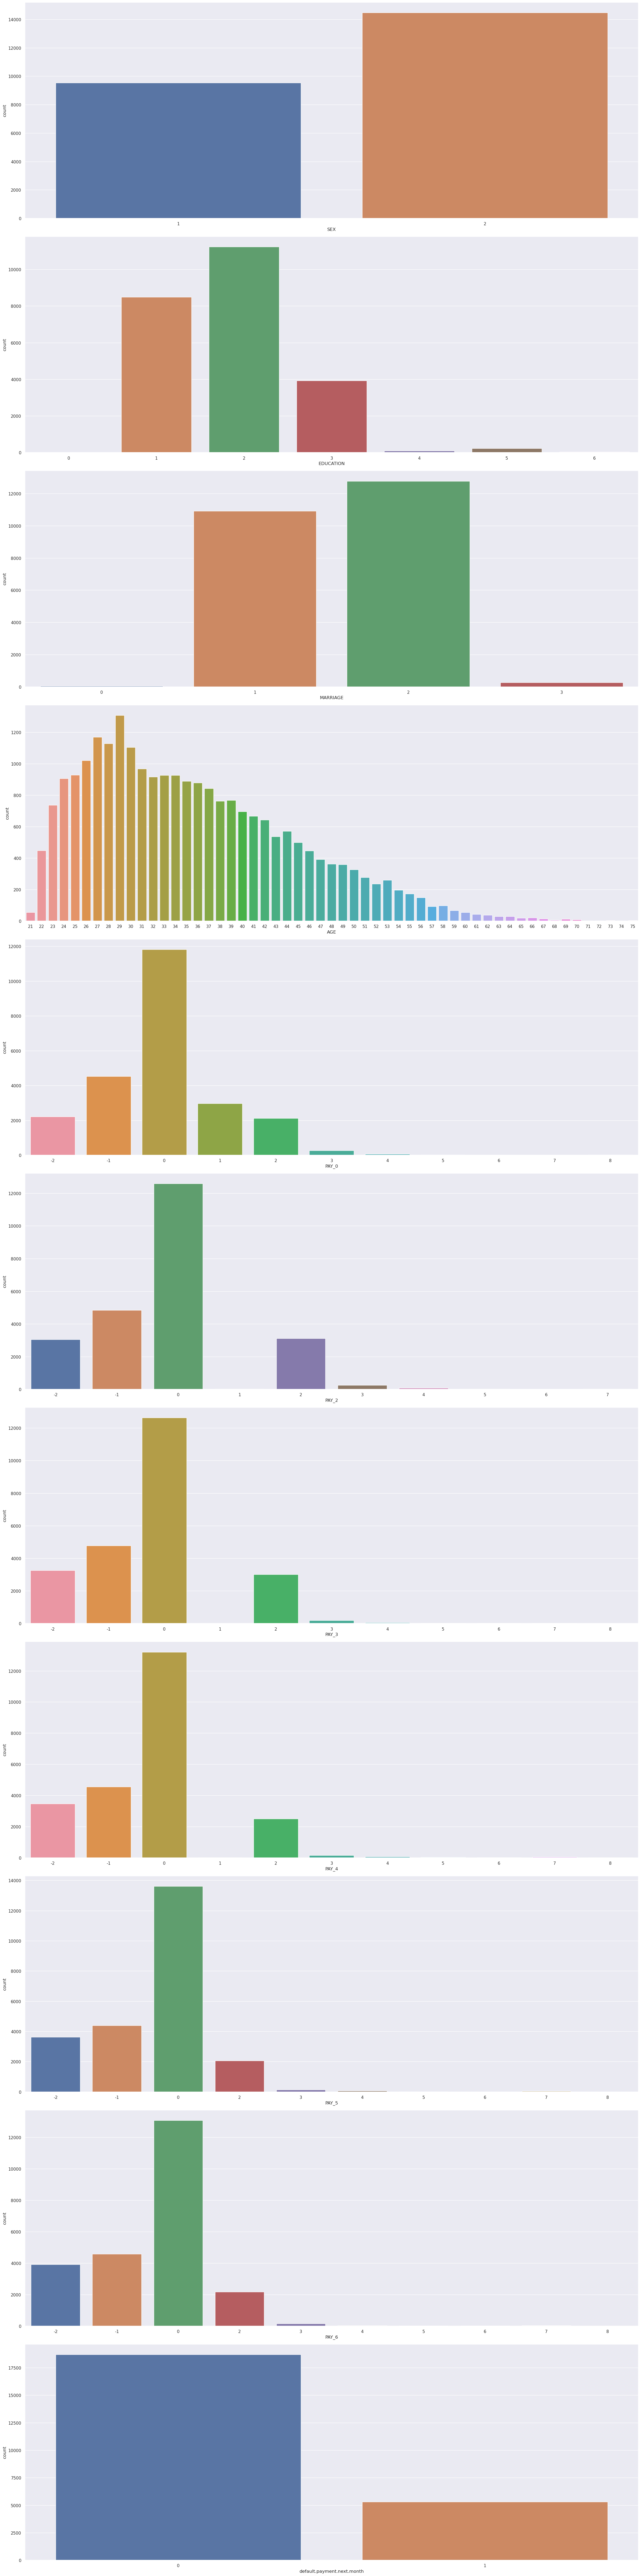

In [8]:
# Distribution of categorical data
categorical = data.select_dtypes(include='category')
f, axes = plt.subplots(len(categorical.columns), figsize=(24, 96))
for count, var in enumerate(categorical):
    sns.countplot(x=categorical[var], ax=axes[count])
# Adjust layout and show the figure
plt.tight_layout()
plt.show()

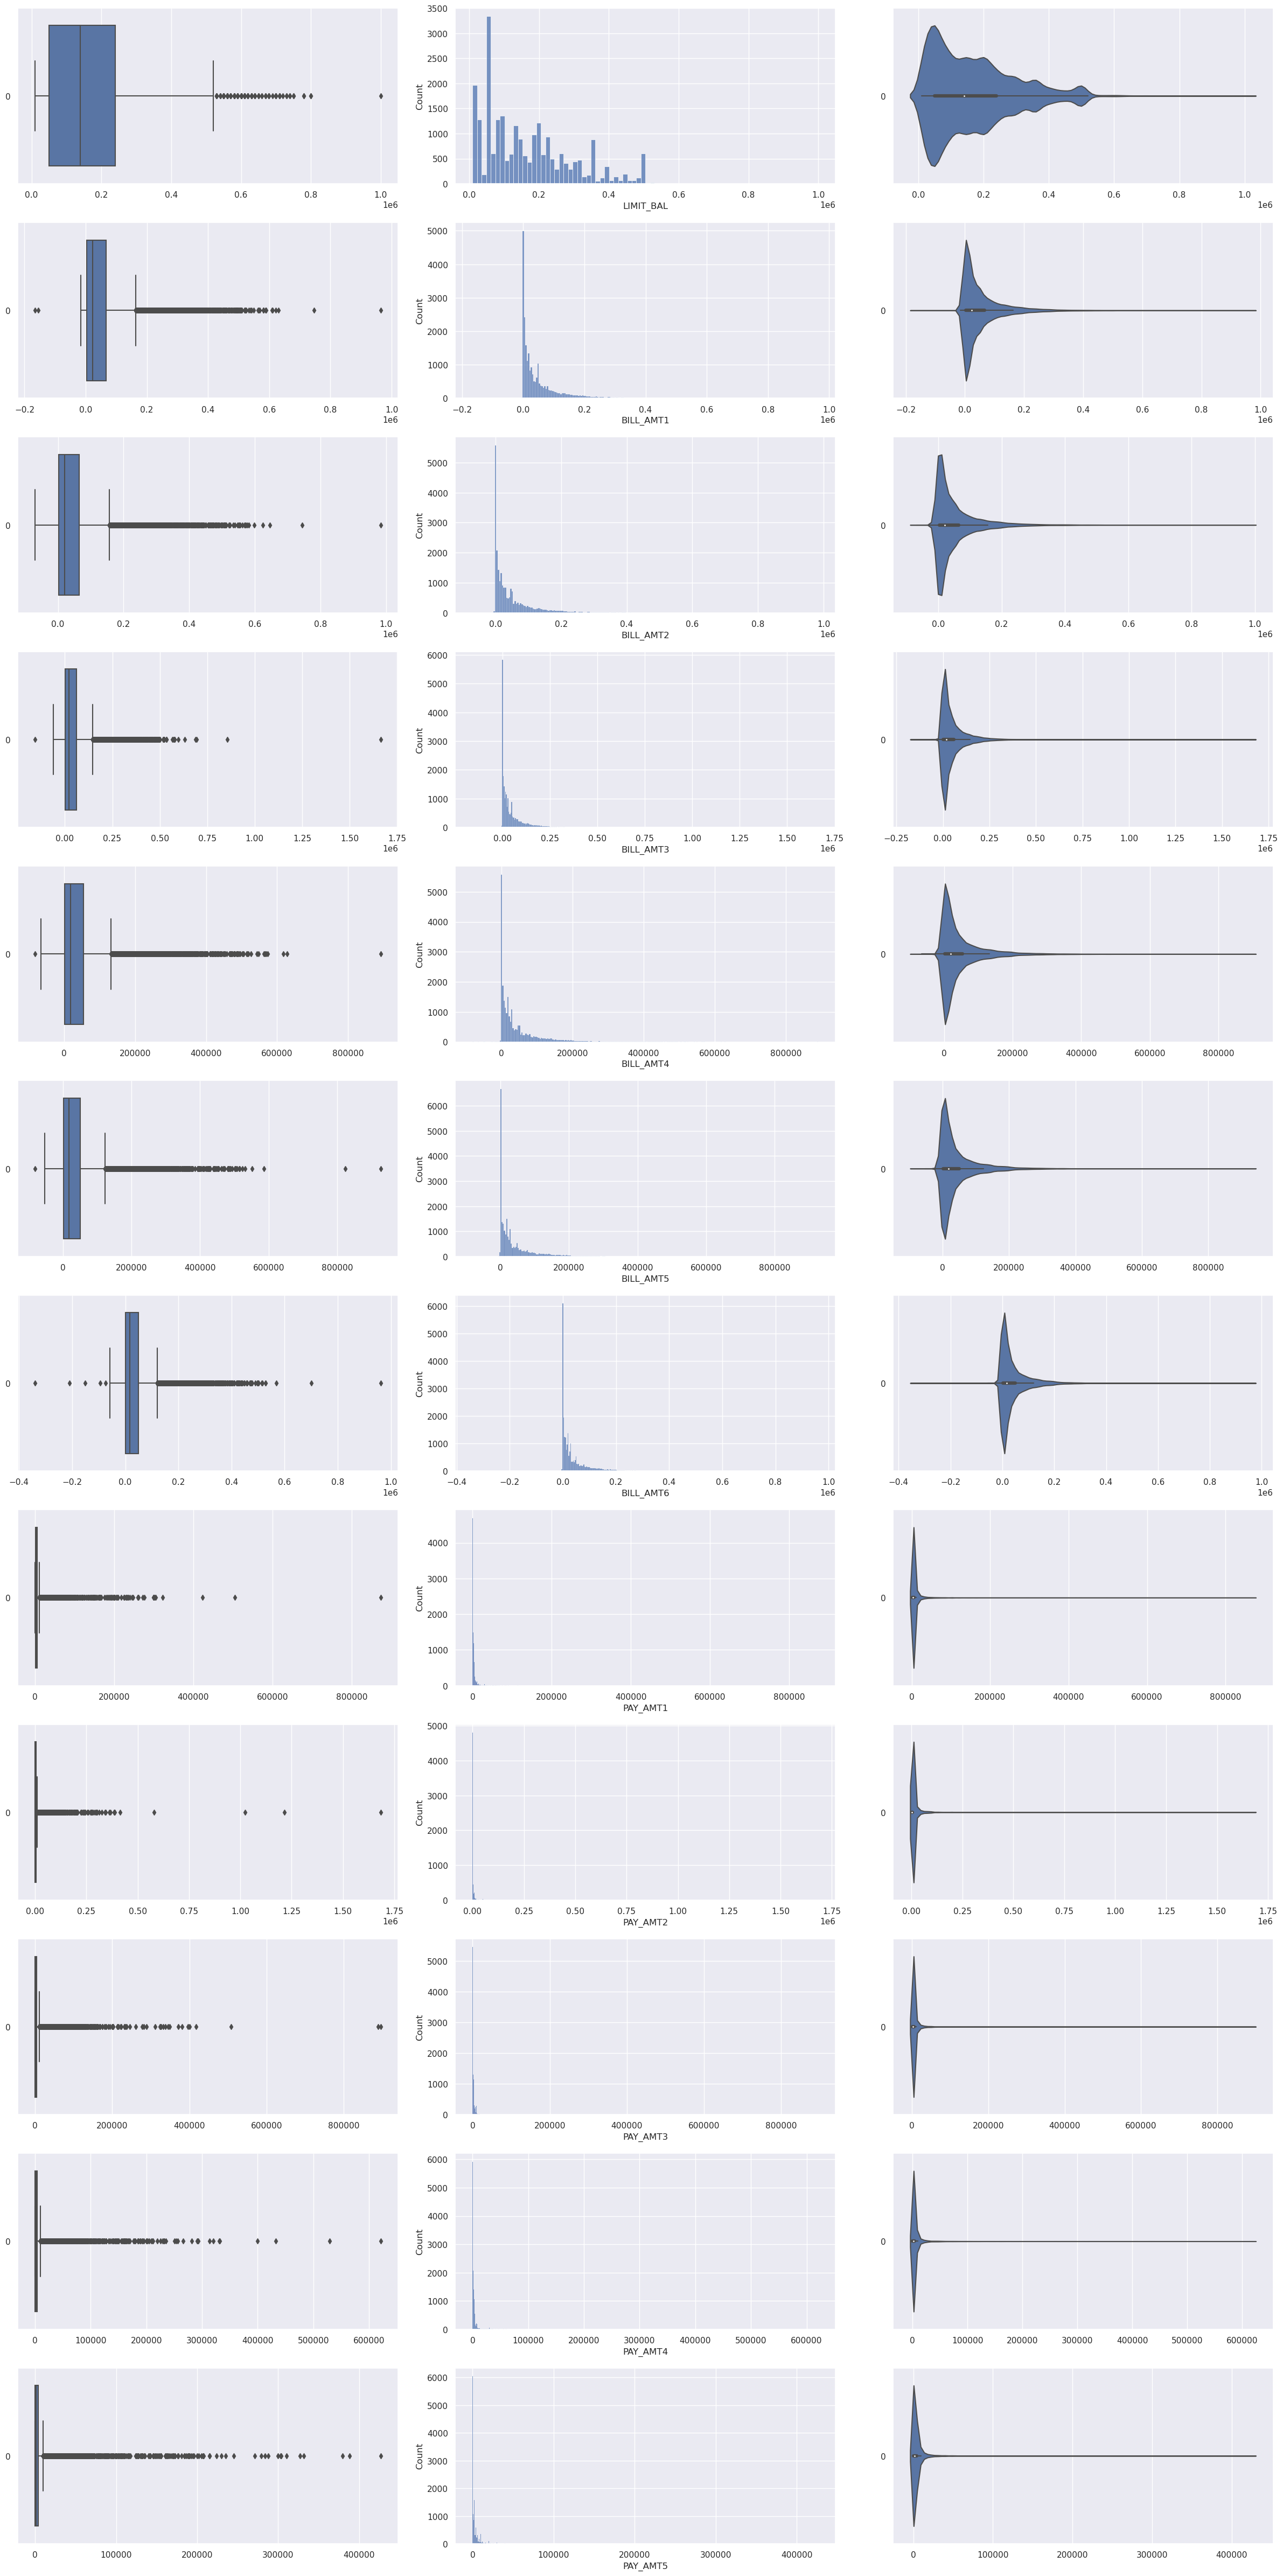

In [9]:
# Distribution of numerical variables
numerical = data.select_dtypes(exclude='category')

f, axes = plt.subplots(len(numerical.columns), 3, figsize=(24, 48))
    
for count, var in enumerate(numerical):
    # Box plot on the first column
    sns.boxplot(data=numerical[var], orient="h", ax=axes[count, 0])

    # Histogram on the second column
    sns.histplot(data=numerical[var], ax=axes[count, 1])

    # Violin plot on the third column
    sns.violinplot(data=numerical[var], orient="h", ax=axes[count, 2])

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

### Analyze

The reason why I use these EDA:
* I first use describe() to gain a basic insight into the data distribution. 
* To observe the correlation between columns, I use a heatmap to visualize the correlation matrix. 
* For categorical data, I prefer using bar charts to display their counts. In comparison to pie charts, bar charts present differences between counts more clearly, even when the counts are close. Therefore, I opt for bar charts instead of pie charts. 
* For numerical data, I use histogram + boxplot + violin plot to visualize. These helps showing the data distribution. Moreover, the boxplot shows the outlier clearly, which is useful for data cleaning.

Here are some information I get:
* The statistic gives basic information for each columns.
* The correlation heatmap shows that the most related features to the prediction are PAY0~PAY6, and also LIMIT_BAL, this insight can help choosing the features in future.
* The barplot of categorical datas shows the distribution of each categorics, and it shows the imbalance problem between two prediction labels.
* The boxplot, histplot, violinplot shows that most of the value in "PAY" columns are in 0~20000, but there are some outlier which are way higher than the others. Also, it shows that there are some outliers in many columns.

Based on the observation, my next steps are:
* Use KNN to clean the outliers.
* Deal with the imbalance label problem (ex. SMOTE).
* Generate new column with high correlated columns to reduce redundency.
* Try to drop some columns that has low correlation between label and see if it helps trainning.


## Data Cleaning

I used KNN to search the outliers of each classes and clean 5% of the outliers.
Based on the discovery in the boxplot in EDA step, there are some outliers in each columns which got extremely large value. Since this exists in many columns, it is hard to determine which sample is the actual outlier by observing each column, so I decided to use KNN to find the outliers so it considers all dimensions.

In [10]:
#clean the outliers of each label by KNN
index_0 = train_y == 0
index_1 = train_y == 1

clear = rawdata.copy()

knn_x_0 = clear[index_0]
knn_x_1 = clear[index_1]

k = 5
distance_metric = 'euclidean'

# Index 0
knn_model = NearestNeighbors(n_neighbors=k, metric=distance_metric)
knn_model.fit(knn_x_0)

distances, indices = knn_model.kneighbors(knn_x_0)

average_distances = np.mean(distances, axis=1)

threshold = np.percentile(average_distances, 95) 

x_cleared_0 = knn_x_0[average_distances < threshold]

#Index 1
knn_model = NearestNeighbors(n_neighbors=k, metric=distance_metric)
knn_model.fit(knn_x_1)

distances, indices = knn_model.kneighbors(knn_x_1)

average_distances = np.mean(distances, axis=1)

threshold = np.percentile(average_distances, 95) 

x_cleared_1 = knn_x_1[average_distances < threshold]

#concat
cleared = pd.concat([x_cleared_0, x_cleared_1], ignore_index=False)
cleared = cleared.sample(frac = 1, random_state = 1).reset_index(drop=True)
cleared

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,default.payment.next.month
0,50000.0,1,2,2,36,0,0,0,0,0,...,6615.0,7131.0,6987.0,6980.0,1300.0,1100.0,1000.0,500.0,500.0,0
1,180000.0,2,2,2,31,0,0,0,0,0,...,178659.0,138243.0,138023.0,137923.0,6814.0,7756.0,4788.0,5100.0,5500.0,0
2,350000.0,2,1,1,41,0,0,0,0,0,...,23489.0,29037.0,36213.0,38163.0,3000.0,6000.0,6000.0,8027.0,8000.0,0
3,210000.0,1,1,2,41,-1,-1,-1,-1,-1,...,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0,1
4,380000.0,1,1,1,37,-1,-1,-1,-1,-1,...,2107.0,0.0,1630.0,0.0,4472.0,2107.0,0.0,1630.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22794,10000.0,1,2,1,44,0,0,2,0,0,...,8794.0,9604.0,9604.0,9800.0,2668.0,0.0,1192.0,0.0,196.0,0
22795,80000.0,2,3,1,26,0,0,0,0,0,...,38141.0,38190.0,38586.0,39962.0,2000.0,1905.0,1350.0,1388.0,2401.0,0
22796,160000.0,1,3,1,46,-1,-1,-1,-1,-1,...,762.0,762.0,762.0,762.0,766.0,762.0,762.0,762.0,762.0,0
22797,100000.0,1,1,2,32,0,0,0,0,0,...,84140.0,86400.0,87275.0,89082.0,4500.0,3300.0,3881.0,2500.0,2519.0,0


## Feature Creation and Integration

According to the heatmap, the correlation between PAY_0 to PAY_6 are high, I decided to create a new column of the mean of each PAY columns and drop them to reduce the redundency.

In [11]:
#AvgPay: average of all columns since they are highly correlated, maybe redundent, Bill five high correlate and low correlate to label -> keep one or drop all
#test with/without low correlation columns and average
#Drop low Correlate
created = rawdata.copy()
Bills = [c for c in cleared.columns if "BILL" in c]
avg_bill = created[Bills].mean(axis=1)
idx = created.columns.get_loc(Bills[0])
created.insert(idx, 'AVG_BILL', avg_bill)
#created.drop(columns = Bills, inplace = True)

test_created = test_x.copy()
avg_bill = test_created[Bills].mean(axis=1)
idx = test_created.columns.get_loc(Bills[0])
test_created.insert(idx, 'AVG_BILL', avg_bill)
#test_created.drop(columns = Bills, inplace = True)


Pays = ['PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5', 'PAY_6']
avg_pay = created[Pays].mean(axis=1)
idx = created.columns.get_loc(Pays[0])
created.insert(idx, 'AVG_PAY', avg_pay)
created.drop(columns = Pays, inplace = True)

avg_pay = test_created[Pays].mean(axis=1)
idx = test_created.columns.get_loc(Pays[0])
test_created.insert(idx, 'AVG_PAY', avg_pay)
test_created.drop(columns = Pays, inplace = True)

## Feature Extraction

There are some columns that has low correlation to the label. I used different threshold to drop the columns with low correlation and compared the result. 

In [12]:
drop_low_001 = cleared.copy()
keep = ['LIMIT_BAL','PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5', 'PAY_6','default.payment.next.month']
drop_low_001 = drop_low_001[keep]

drop_low_003 = created.copy()
keep = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AVG_BILL', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']
drop_low_003 = drop_low_003[keep]

## Imbalanced Data

I selected SMOTE and TomekLinks to deal with the imbalance problem, since SMOTE generates new data from the train set instead of copying a data point, and TomeLinks can drop some data points that are close to decision boundary.

# Training & Testing

I used KFold to do cross validation and tried original dataset, KNN cleared dataset, dropped low correlation dataset and dataset with custom created column. By setting 'balance' and 'tome' parameter, we can turn the imbalance progress on or off to compare the result.

In [13]:
kfc = KFold(n_splits= 8, random_state=1, shuffle=True)

Fold  1
Accuracy:  0.8296666666666667
Precision:  0.657608695652174
Recall:  0.38596491228070173


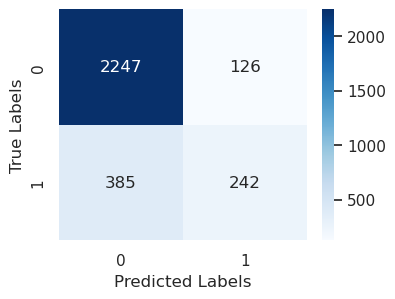

Fold  2
Accuracy:  0.8186666666666667
Precision:  0.651595744680851
Recall:  0.3723404255319149


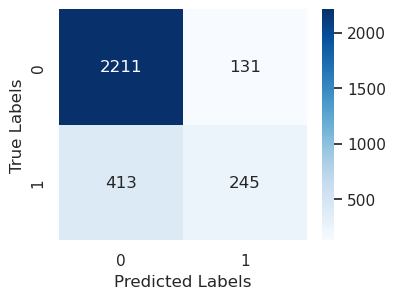

Fold  3
Accuracy:  0.8023333333333333
Precision:  0.5826330532212886
Recall:  0.31901840490797545


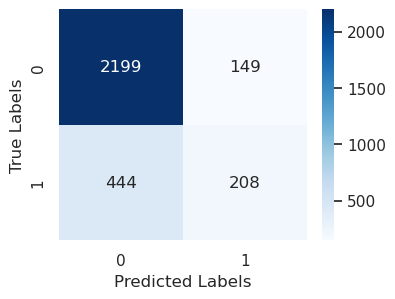

Fold  4
Accuracy:  0.8266666666666667
Precision:  0.6808510638297872
Recall:  0.3902439024390244


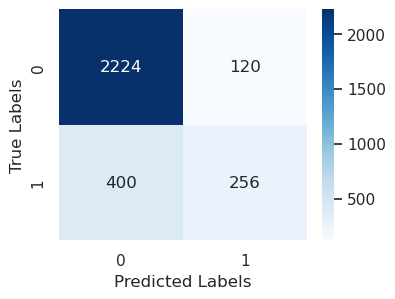

Fold  5
Accuracy:  0.8176666666666667
Precision:  0.652605459057072
Recall:  0.3925373134328358


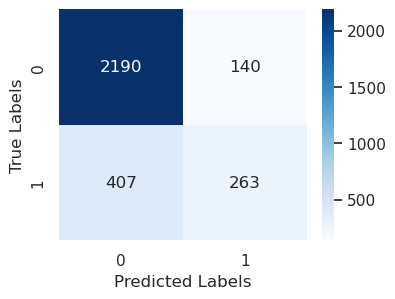

Fold  6
Accuracy:  0.8176666666666667
Precision:  0.6982543640897756
Recall:  0.39660056657223797


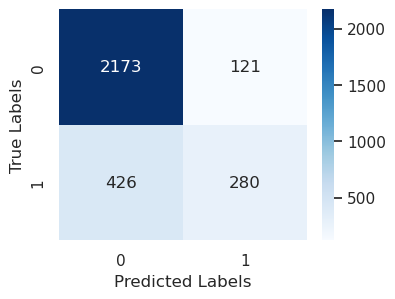

Fold  7
Accuracy:  0.8113333333333334
Precision:  0.643646408839779
Recall:  0.34776119402985073


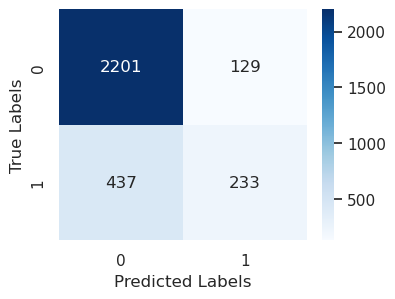

Fold  8
Accuracy:  0.8206666666666667
Precision:  0.6734177215189874
Recall:  0.3940740740740741


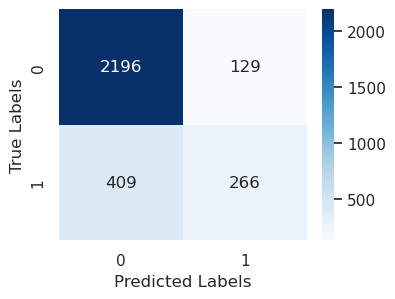

In [14]:
#Original Dataset
balance = False
tome = False

if balance:
    train_x, train_y = SMOTE().fit_resample(train_x, train_y)
if tome:
    train_x, train_y = TomekLinks().fit_resample(train_x, train_y)

for i,(train_index, valid_index) in enumerate(kfc.split(train_x)):
    print('Fold ',i+1)
    x_train = train_x.iloc[train_index]
    y_train = train_y.iloc[train_index]
    
    x_valid = train_x.iloc[valid_index]
    y_valid = train_y.iloc[valid_index]
    model=RandomForestClassifier(n_estimators = 200)
    model.fit(x_train, y_train)
    ypredict = model.predict(x_valid)
    show_result(y_valid, ypredict)
    

model=RandomForestClassifier(n_estimators = 200)
model.fit(train_x, train_y)
ypredict=model.predict_proba(test_x)
ypredict = [pair[1] for pair in ypredict]
generate_csv(ypredict, 'Original.csv')

Fold  1
Accuracy:  0.8214035087719298
Precision:  0.6518324607329843
Recall:  0.3984


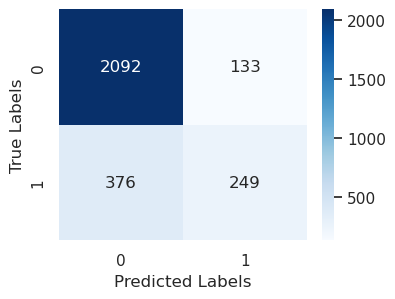

Fold  2
Accuracy:  0.8182456140350877
Precision:  0.6208791208791209
Recall:  0.37293729372937295


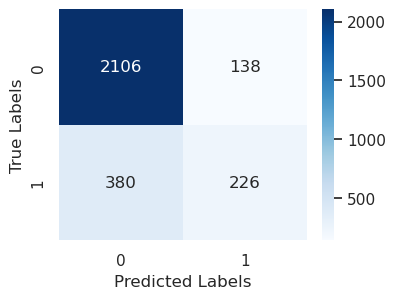

Fold  3
Accuracy:  0.8108771929824561
Precision:  0.6219839142091153
Recall:  0.3682539682539683


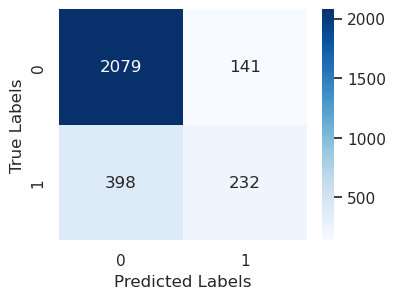

Fold  4
Accuracy:  0.8171929824561404
Precision:  0.6461538461538462
Recall:  0.3968503937007874


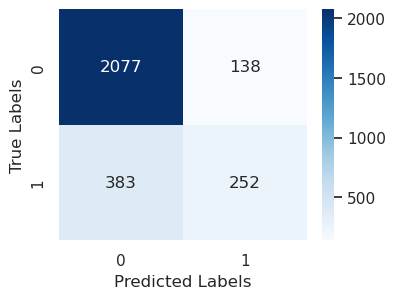

Fold  5
Accuracy:  0.8147368421052632
Precision:  0.6774193548387096
Recall:  0.38181818181818183


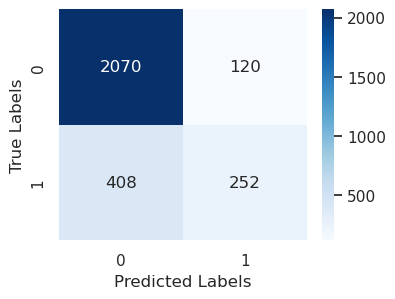

Fold  6
Accuracy:  0.8196491228070175
Precision:  0.6346153846153846
Recall:  0.37745098039215685


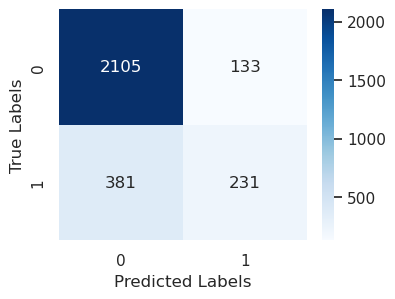

Fold  7
Accuracy:  0.8294736842105264
Precision:  0.672566371681416
Recall:  0.3781094527363184


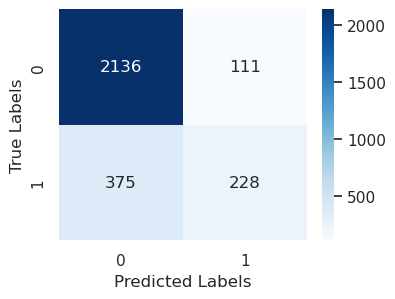

Fold  8
Accuracy:  0.8104598104598104
Precision:  0.6940509915014165
Recall:  0.361890694239291


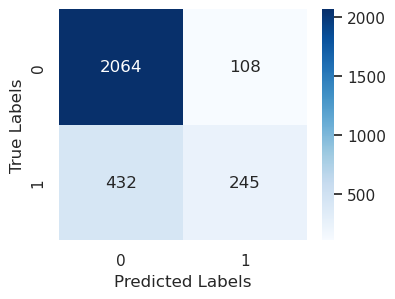

In [15]:
#KNN Cleared Dataset
balance = False
tome = False
train_x = cleared.iloc[:, 0:-1]
train_y = cleared.iloc[:, -1]

if balance:
    train_x, train_y = SMOTE().fit_resample(train_x, train_y)
if tome:
    train_x, train_y = TomekLinks().fit_resample(train_x, train_y)
    
for i,(train_index, valid_index) in enumerate(kfc.split(train_x)):
    print('Fold ',i+1)
    x_train = train_x.iloc[train_index]
    y_train = train_y.iloc[train_index]
    
    x_valid = train_x.iloc[valid_index]
    y_valid = train_y.iloc[valid_index]
    model=RandomForestClassifier(n_estimators = 200)
    model.fit(x_train, y_train)
    ypredict = model.predict(x_valid)
    show_result(y_valid, ypredict)

model=RandomForestClassifier(n_estimators = 200)
model.fit(train_x, train_y)

ypredict=model.predict_proba(test_x)
ypredict = [pair[1] for pair in ypredict]
generate_csv(ypredict, 'cleared_Result.csv')

Fold  1
Accuracy:  0.8063157894736842
Precision:  0.5835240274599542
Recall:  0.408


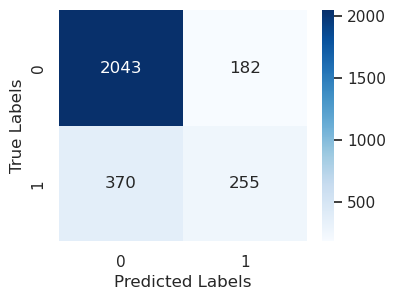

Fold  2
Accuracy:  0.8112280701754386
Precision:  0.585
Recall:  0.38613861386138615


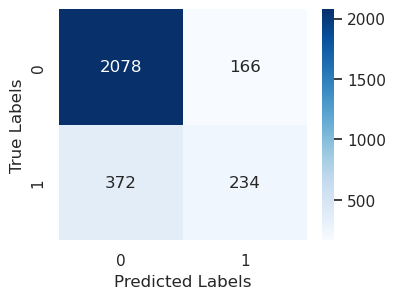

Fold  3
Accuracy:  0.7964912280701755
Precision:  0.5625
Recall:  0.35714285714285715


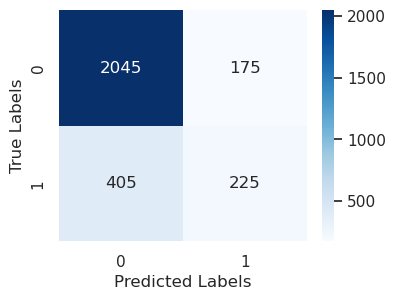

Fold  4
Accuracy:  0.7996491228070175
Precision:  0.5720720720720721
Recall:  0.4


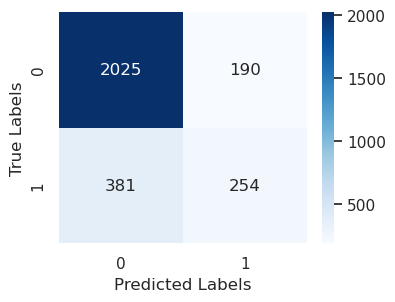

Fold  5
Accuracy:  0.803859649122807
Precision:  0.6240786240786241
Recall:  0.38484848484848483


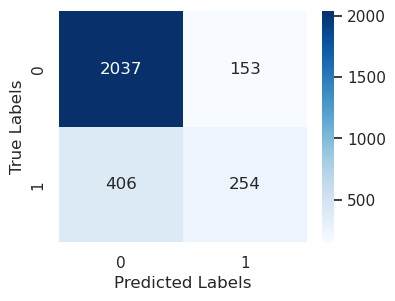

Fold  6
Accuracy:  0.8066666666666666
Precision:  0.578005115089514
Recall:  0.369281045751634


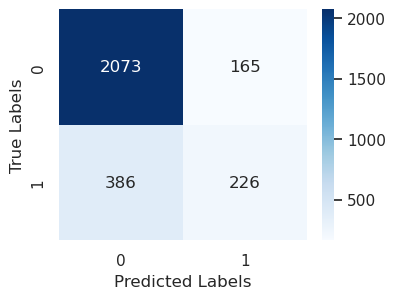

Fold  7
Accuracy:  0.8119298245614035
Precision:  0.58656330749354
Recall:  0.37645107794361526


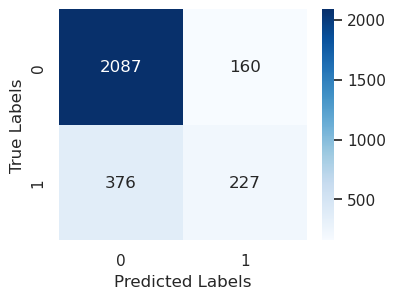

Fold  8
Accuracy:  0.7960687960687961
Precision:  0.6237113402061856
Recall:  0.35745937961595275


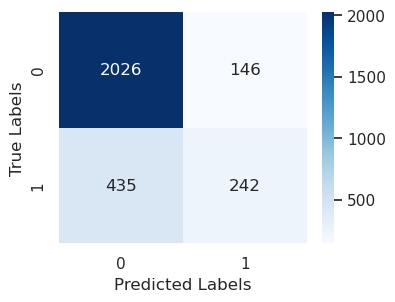

In [16]:
# Dropped Low Correlation
balance = False
tome = False
train_x = drop_low_001.iloc[:, 0:-1]
train_y = drop_low_001.iloc[:, -1]

if balance:
    train_x, train_y = SMOTE().fit_resample(train_x, train_y)
if tome:
    train_x, train_y = TomekLinks().fit_resample(train_x, train_y)

for i,(train_index, valid_index) in enumerate(kfc.split(train_x)):
    print('Fold ',i+1)
    x_train = train_x.iloc[train_index]
    y_train = train_y.iloc[train_index]
    
    x_valid = train_x.iloc[valid_index]
    y_valid = train_y.iloc[valid_index]
    model=RandomForestClassifier(n_estimators = 200)
    model.fit(x_train, y_train)
    ypredict = model.predict(x_valid)
    show_result(y_valid, ypredict)

model=DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state=1)
model.fit(train_x, train_y)
test_x = test_x[['LIMIT_BAL','PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5', 'PAY_6']]
ypredict=model.predict_proba(test_x)
ypredict = [pair[1] for pair in ypredict]
generate_csv(ypredict, 'drop_low_Result.csv')

Fold  1
Accuracy:  0.8126666666666666
Precision:  0.5987841945288754
Recall:  0.3141945773524721


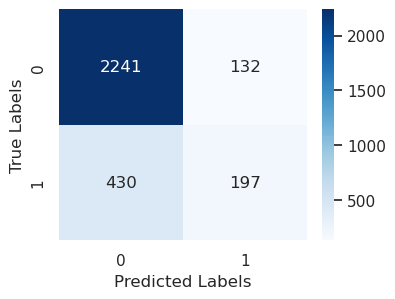

Fold  2
Accuracy:  0.8093333333333333
Precision:  0.6272189349112426
Recall:  0.3221884498480243


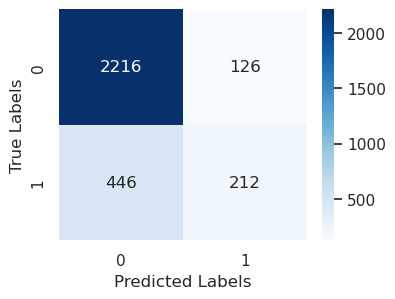

Fold  3
Accuracy:  0.8033333333333333
Precision:  0.5846994535519126
Recall:  0.3282208588957055


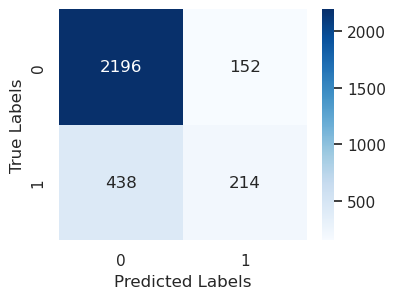

Fold  4
Accuracy:  0.811
Precision:  0.6260623229461756
Recall:  0.33689024390243905


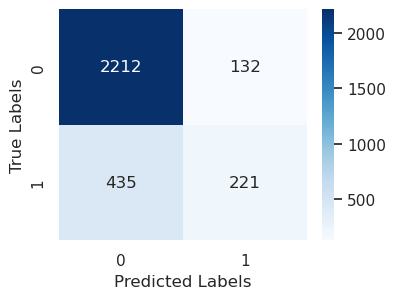

Fold  5
Accuracy:  0.7996666666666666
Precision:  0.5940054495912807
Recall:  0.3253731343283582


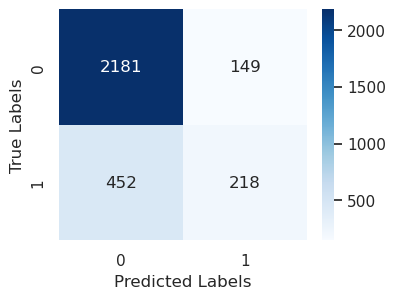

Fold  6
Accuracy:  0.7956666666666666
Precision:  0.6214099216710183
Recall:  0.3371104815864023


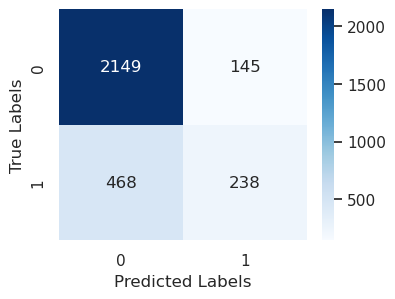

Fold  7
Accuracy:  0.798
Precision:  0.5935672514619883
Recall:  0.3029850746268657


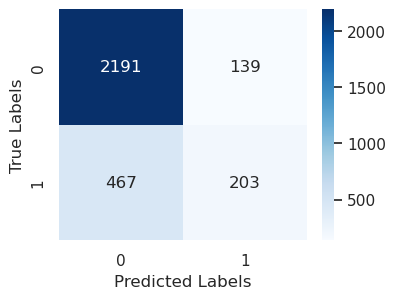

Fold  8
Accuracy:  0.8096666666666666
Precision:  0.6382978723404256
Recall:  0.35555555555555557


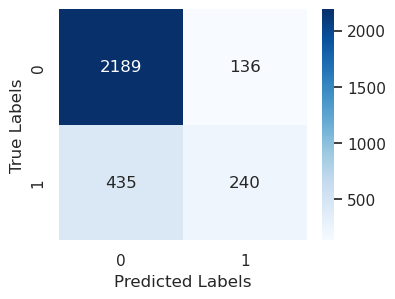

In [17]:
# Use Custom Created Column

balance = False
tome = False
train_x = created.iloc[:, 0:-1]
train_y = created.iloc[:, -1]

if balance:
    train_x, train_y = SMOTE().fit_resample(train_x, train_y)
if tome:
    train_x, train_y = TomekLinks().fit_resample(train_x, train_y)
    
for i,(train_index, valid_index) in enumerate(kfc.split(train_x)):
    print('Fold ',i+1)
    x_train = train_x.iloc[train_index]
    y_train = train_y.iloc[train_index]
    
    x_valid = train_x.iloc[valid_index]
    y_valid = train_y.iloc[valid_index]
    model=RandomForestClassifier(n_estimators = 200)
    model.fit(x_train, y_train)
    ypredict = model.predict(x_valid)
    show_result(y_valid, ypredict)    


model=RandomForestClassifier(n_estimators = 200)
model.fit(train_x, train_y)

ypredict=model.predict_proba(test_created)
ypredict = [pair[1] for pair in ypredict]
generate_csv(ypredict, 'created_Result.csv')

## Result and Discussion
* The test result of orignial dataset is 0.79488.
* Using KNN with 95% threshold to clear outliers slightly increases the test score by 0.00044. However, if I decrease the threshold to 90%, the performance will drop to 0.78613. It might because too many data points are discarded and loss some information.
* For SMOTE and Tomelinks, it dosen't help the performance in this task. If I use both, the score dropped to 0.75439, and the perfornabce also drop even if I use only one of them. One possible reason is that the sampled points are too close to each other and it cause overfit.
* After discarding all low correlation features, the performance dropped to 0.71346, which shows that even if the features didn't have direct relationship to the label, they might still contains some important information.
* Using created feature doesn't seems to help the performance, maybe there are some other ways to create columns that are more suitable to the dataset.